In [32]:
import os
import sys
import shutil

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [34]:
import scipy
import sklearn

In [35]:
import tensorflow as tf
from tensorflow import keras

In [36]:
import string
import re

In [37]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [38]:
!unzip /content/drive/MyDrive/sms.zip

Archive:  /content/drive/MyDrive/sms.zip
replace spam.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: spam.csv                


In [39]:
path = '/content/spam.csv'

In [40]:
data = pd.read_csv(path, encoding="ISO-8859-1")

In [41]:
data.head(10)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


In [42]:
print(data.shape)
data.info()

(5572, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [43]:
data.columns = data.columns.str.strip()

columns = ['Unnamed: 2','Unnamed: 3','Unnamed: 4']
data = data.drop(columns=columns, axis=1)

data.rename(columns = {'v1':'label','v2':'text'}, inplace = True)

In [44]:
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [45]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def process_text(message):
    text_split = message.lower().split()
    texts = [word for word in text_split if word not in string.punctuation]
    texts = [re.sub("[^a-zA-Z]", " ", word).strip() for word in texts]
    texts = " ".join(texts)
    texts = [word for word in texts.split() if word not in stop_words and len(word)>1]

    return " ".join(texts)

data['text'] = data['text'].apply(process_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
le = preprocessing.LabelEncoder()
data['label'] = le.fit_transform(data['label'])

data.reset_index(drop=True, inplace=True)

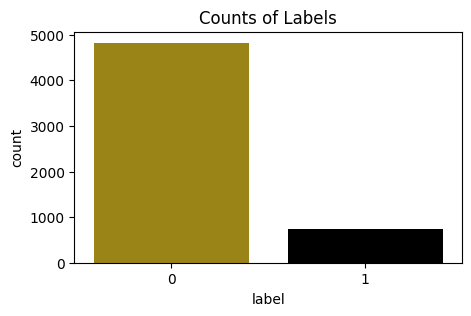

In [47]:
fig = plt.figure(figsize=(5, 3))
sns.countplot(data, x='label', palette=["#b09302", "#000000"])
plt.title("Counts of Labels")
plt.show()

In [48]:
X = data['text']
y = data['label']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_tfidf = TfidfVectorizer(stop_words='english')
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

In [50]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

MultinomialNB()

In [51]:
y_pred = model.predict(X_test_tfidf)

In [52]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.97
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       975
           1       1.00      0.78      0.88       140

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115



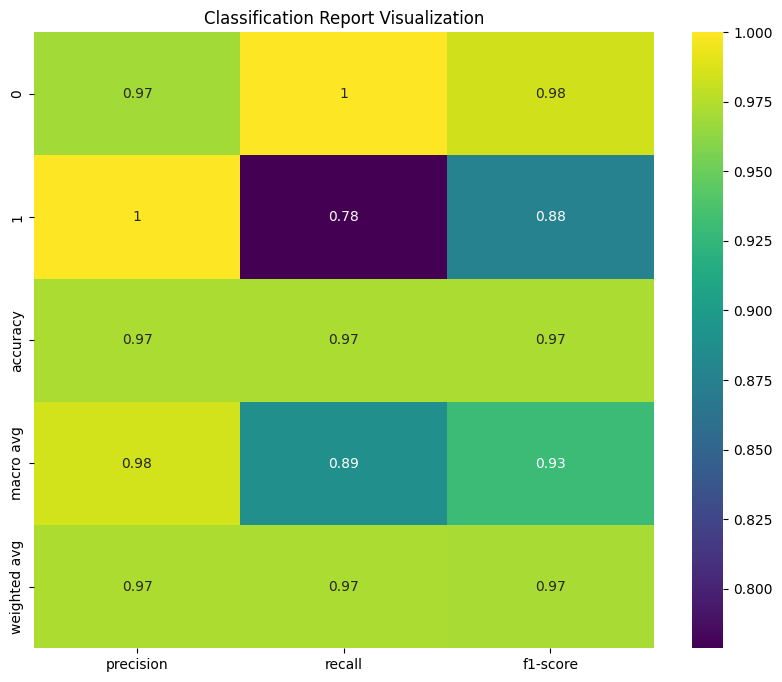

In [53]:
plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame.from_dict(classification_report(y_test, y_pred, output_dict=True)).iloc[:-1, :].T, annot=True, cmap='viridis')
plt.title('Classification Report Visualization')
plt.show()

In [54]:
import joblib

joblib.dump(model, 'spam_filter_model.joblib')

['spam_filter_model.joblib']

In [55]:
loaded_model = joblib.load('spam_filter_model.joblib')

In [57]:
new_message =  ["Congratulations, you've won a prize!"]
new_message_tfidf = vectorizer_tfidf.transform(new_message)
prediction = loaded_model.predict(new_message_tfidf)

print('Prediction for new message:')
for message, pred in zip(new_message, prediction):
    if pred == 0:
        print(f'Message: {message}\nPrediction: {prediction} which is Spam\n')
    else:
        print(f'Message: {message}\nPrediction: {prediction} which is Ham\n')

Prediction for new message:
Message: Congratulations, you've won a prize!
Prediction: [1] which is Ham

